# 

In [1]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.denoising_model import SimpleMLPTimeStep
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.utils import unsqueeze_right

device  = "cuda" if torch.cuda.is_available() else "cpu"

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


**Read checkpoints and check denoising model**

In [2]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/fm_resnet_encoder_fact_dentate/7c90d37a-6ca7-4473-ba7a-738a91575385/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model

MLPTimeStep(
  (time_embedder): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (condition_embedder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (net_in): Linear(in_features=2000, out_features=512, bias=True)
  (blocks): ModuleList(
    (0-1): 2 x ResnetBlock(
      (net1): Sequential(
        (0): SiLU()
        (1): Linear(in_features=512, out_features=512, bias=True)
      )
      (cond_proj_time): Sequential(
        (0): SiLU()
        (1): Linear(in_features=512, out_features=512, bias=True)
      )
      (cond_proj_covariate): Sequential(
        (0): SiLU()
        (1): Linear(in_features=512, out_features=512, bias=True)
      )
      (net2): Sequential(
        (0): SiLU()
        (1): Linear(in_features=512, out_features=512, bias=True)
      )
    )
  )

In [3]:
list(denoising_model.time_embedder.parameters())[0]

Parameter containing:
tensor([[ 0.0031, -0.0021,  0.0251,  ..., -0.0025, -0.0025, -0.0025],
        [-0.0079, -0.0066, -0.0028,  ...,  0.0004,  0.0004,  0.0004],
        [ 0.0182,  0.0361, -0.0469,  ..., -0.0208, -0.0195, -0.0240],
        ...,
        [-0.0015,  0.0008,  0.0039,  ..., -0.0025, -0.0025, -0.0025],
        [-0.0148, -0.0078, -0.0002,  ..., -0.0547, -0.0547, -0.0547],
        [-0.0057, -0.0132, -0.0093,  ...,  0.0025,  0.0025,  0.0025]],
       device='cuda:0', requires_grad=True)

In [4]:
# list(denoising_model.size_factor_embedder.parameters())[0]

In [5]:
list(denoising_model.condition_embedder.parameters())[0]

Parameter containing:
tensor([[ 0.0042,  0.0015, -0.0016,  ..., -0.0030,  0.0042,  0.0020],
        [ 0.0009,  0.0006,  0.0004,  ...,  0.0004,  0.0010,  0.0012],
        [ 0.0012,  0.0007, -0.0019,  ..., -0.0025,  0.0025, -0.0010],
        ...,
        [ 0.0019,  0.0007, -0.0048,  ..., -0.0072,  0.0035, -0.0009],
        [ 0.0020,  0.0010, -0.0016,  ..., -0.0021,  0.0020,  0.0006],
        [-0.0004,  0.0003,  0.0034,  ...,  0.0056, -0.0004, -0.0002]],
       device='cuda:0', requires_grad=True)

**Check features**

In [6]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["clusters"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[-0.0021, -0.0027,  0.0048,  ...,  0.0087, -0.0041, -0.0028],
        [-0.0070, -0.0036,  0.0076,  ...,  0.0059, -0.0045, -0.0024],
        [-0.0140, -0.0125,  0.0023,  ...,  0.0033, -0.0148, -0.0182],
        ...,
        [ 0.0013, -0.0019, -0.0097,  ..., -0.0052, -0.0026, -0.0098],
        [ 0.0035, -0.0036,  0.0116,  ...,  0.0105,  0.0027,  0.0007],
        [ 0.0043,  0.0031,  0.0108,  ...,  0.0065,  0.0068,  0.0096]],
       device='cuda:0', requires_grad=True)


**Config**

In [7]:
dataset_config = {'dataset_path': '../../datasets/processed/dentategyrus.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['clusters'],
                    'sampling_covariate': 'clusters',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_encoder',
                    'target_max': 1,
                    'target_min': -1,
                    'n_dimensions': None,
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': 256}

generative_model_config = {'x0_from_x_kwargs': {
                                'dims': [512, 512],
                                'batch_norm': True,
                                'dropout': False,
                                'dropout_p': 0.0
                            },
                            'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'scaling_method': 'log_normalization',
                            'pretrain_encoder': True,
                            'pretraining_encoder_epochs': 200,
                            'sigma': 0.001,
                            'covariate_specific_theta': False
                        }

**Initialization**

Initialize dataset 

In [8]:
data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                        layer_key=dataset_config["layer_key"],
                        covariate_keys=dataset_config["covariate_keys"],
                        subsample_frac=dataset_config["subsample_frac"], 
                        encoder_type=dataset_config["encoder_type"],
                        target_max=dataset_config["target_max"], 
                        target_min=dataset_config["target_min"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Initialize VDM 

In [9]:
generative_model = FM(
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=in_dim,
            size_factor_statistics=size_factor_statistics,
            scaler=None,
            encoder_type=dataset_config["encoder_type"],
            model_type=denoising_model.model_type,
            conditioning_covariate="clusters",
            **generative_model_config  # model_kwargs should contain the rest of the arguments
        )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (denoising_model): MLPTimeStep(
    (time_embedder): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (condition_embedder): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (net_in): Linear(in_features=2000, out_features=512, bias=True)
    (blocks): ModuleList(
      (0-1): 2 x ResnetBlock(
        (net1): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=512, bias=True)
        )
        (cond_proj_time): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=512, bias=True)
        )
        (cond_proj_covariate): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=512, bias=True)
        )
        (net2): Sequential(
          (0): SiLU()
    

**Check the data**

In [10]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
X = torch.tensor(adata_original.layers["X_counts"].todense())

**Collect checkpoints and run**

General conditional

In [11]:
num_indices = 18000
index_range = len(X)

# Generate random dummy indices without replacement
indices = random.sample(range(index_range), num_indices)
adata_indices = adata_original[indices]

condition_names =  list(adata_indices.obs.clusters)
classes = torch.tensor([dataset.id2cov["clusters"][c] for  c in condition_names]).cuda()

log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()

In [12]:
X_generated = generative_model.batched_sample(batch_size=1800,
                                                repetitions=10,
                                                n_sample_steps=100, 
                                                covariate="clusters", 
                                                covariate_indices=classes, 
                                                log_size_factor=log_size_factors)

X_generated = X_generated.to("cpu")

In [13]:
X_generated

tensor([[ 0.,  0.,  0.,  ...,  0.,  0., 77.],
        [ 0.,  0.,  1.,  ...,  0.,  0.,  4.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  6.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  2.]])

Single condition

In [14]:
# dataset.id2cov["clusters"]

In [15]:
# # Pick condition 
# condition_name = 'RadialGlia2'
# condition_val = dataset.id2cov["clusters"][condition_name]
# adata_cond = adata_original[adata_original.obs.clusters==condition_name]
# n_to_generate = adata_cond.shape[0]

# condition_names = [condition_name for _ in range(n_to_generate)] 

# classes = condition_val*torch.ones(n_to_generate).long()

# log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [16]:
# X_generated = generative_model.sample(batch_size=n_to_generate,
#                                         n_sample_steps=2, 
#                                         covariate="clusters", 
#                                         covariate_indices=classes, 
#                                         log_size_factor=log_size_factors)

# X_generated = X_generated.to("cpu")

**Create adata and check plots**

In [17]:
cell_type_df = pd.DataFrame(condition_names)
cell_type_df.columns = ["cell_type"]
adata_generated = sc.AnnData(X=deepcopy(X_generated).cpu().numpy(), 
                            obs=cell_type_df)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [18]:
sc.pp.log1p(adata_generated)
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

In [19]:
adata_generated.obs["size_factor"] = adata_generated.X.sum(1)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


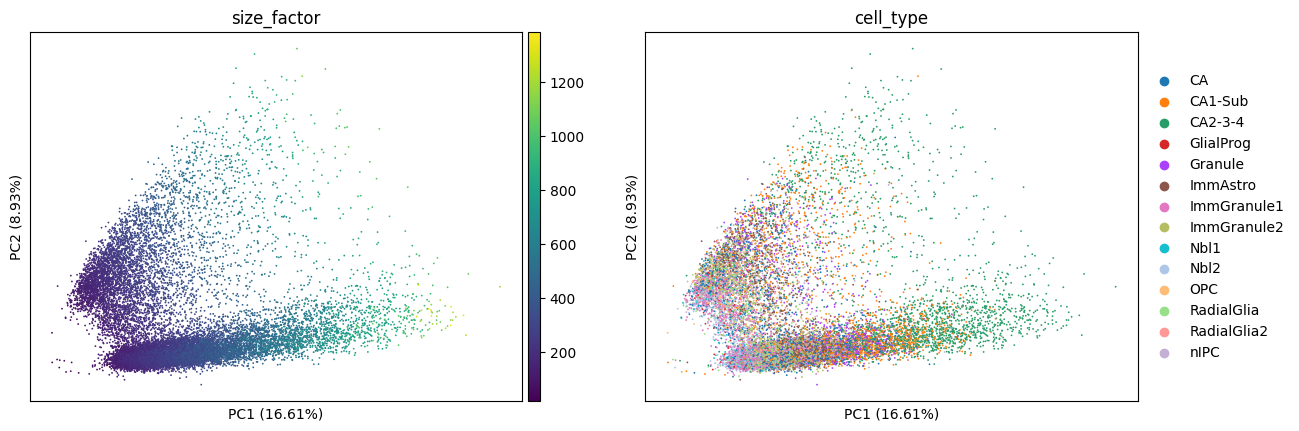

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


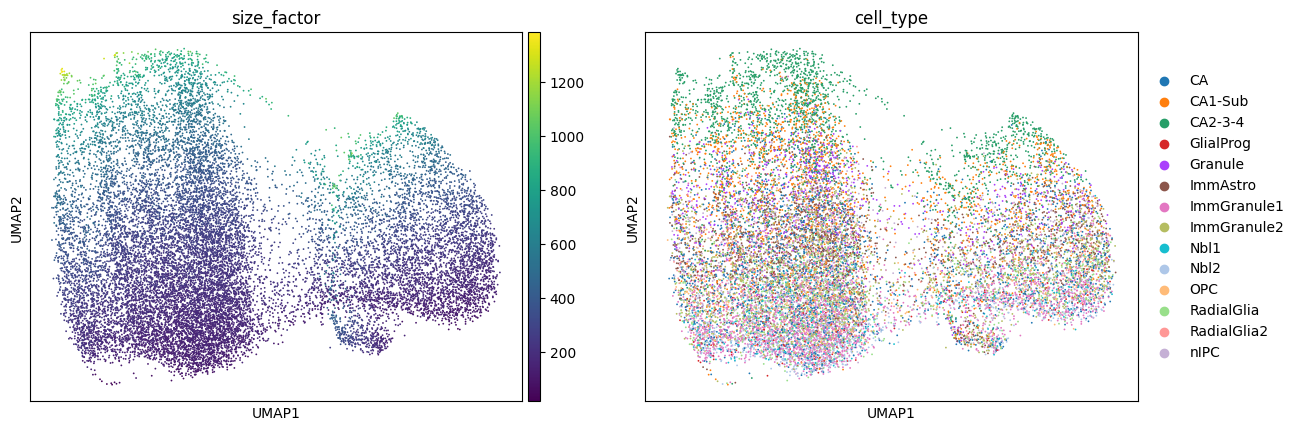

In [20]:
sc.pl.pca(adata_generated, color=["size_factor", "cell_type"], annotate_var_explained=True)
sc.pl.umap(adata_generated, color=["size_factor", "cell_type"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


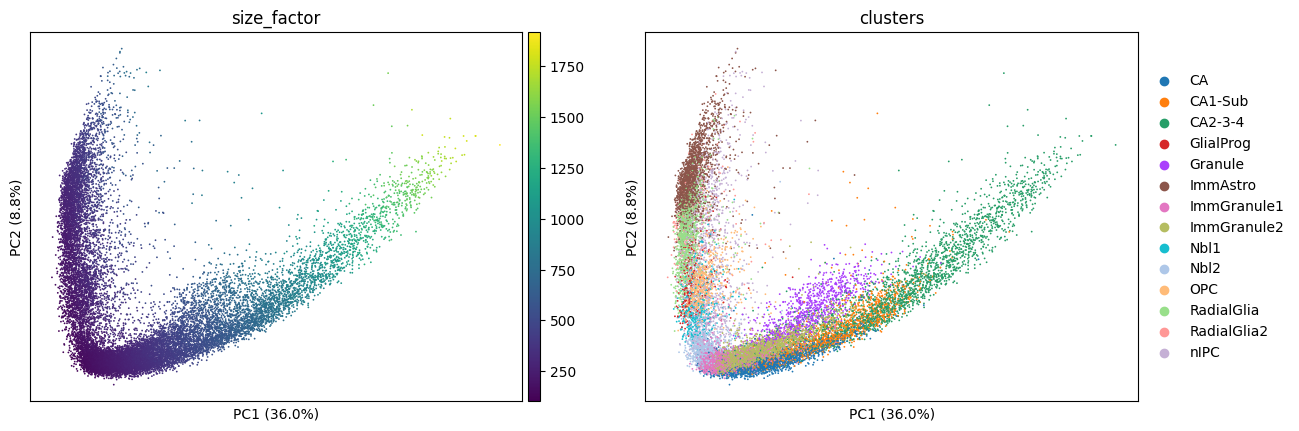

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


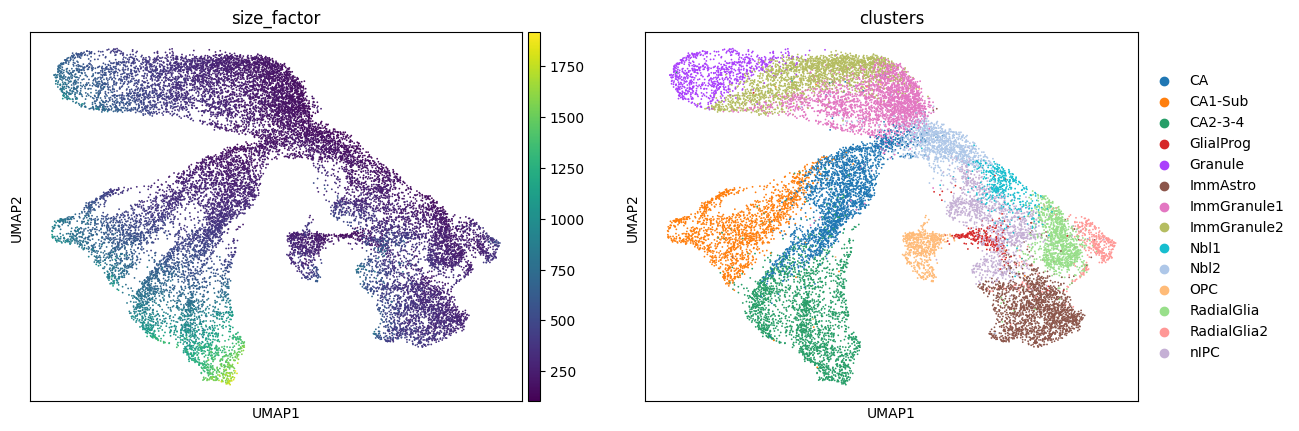

In [21]:
sc.pl.pca(adata_original, color=["size_factor", "clusters"],  annotate_var_explained=True)
sc.pl.umap(adata_original, color=["size_factor", "clusters"])

In [22]:
dataset_type = ["Real" for _ in range(X.shape[0])] + ["Generated" for _ in range(X_generated.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]

In [23]:
# If applicable 
cell_type = list(adata_original.obs.clusters) + condition_names
dataset_type["cell_type"] = cell_type

Merge and plot the generated and real data

In [24]:
adata_merged = sc.AnnData(X=torch.cat([X, X_generated], dim=0).numpy(), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [25]:
adata_original

AnnData object with n_obs × n_vars = 18213 × 2000
    obs: 'Age', 'clusters', 'size_factor'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts', 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [26]:
# sc.pp.normalize_total(adata_merged) 
sc.pp.log1p(adata_merged) 
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

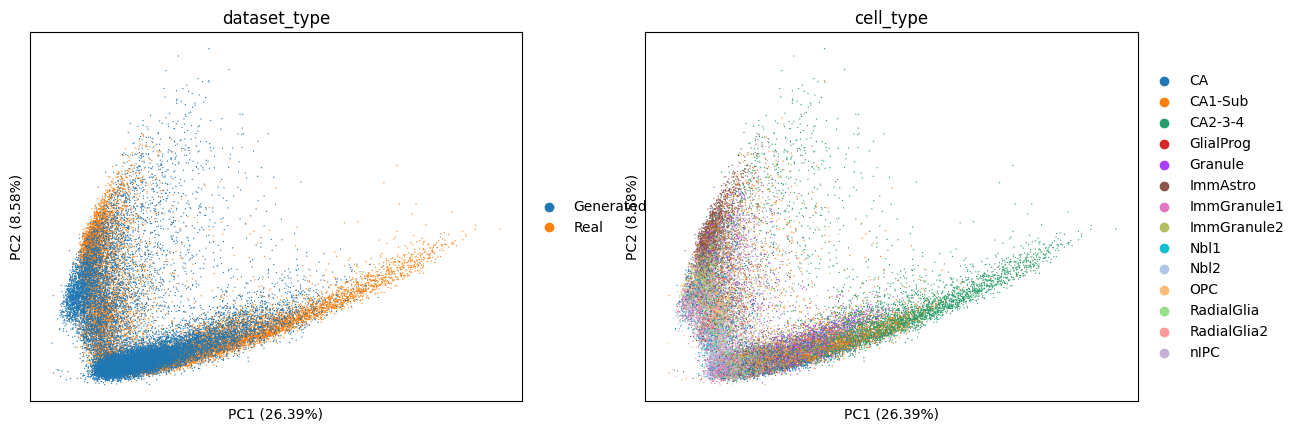

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

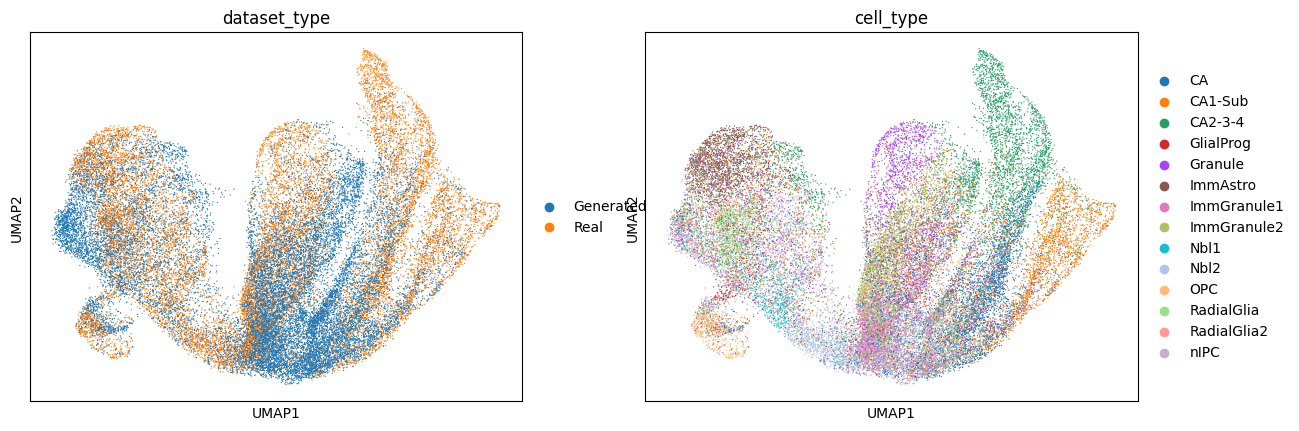

In [27]:
sc.pl.pca(adata_merged, color=["dataset_type", "cell_type"],  annotate_var_explained=True)
sc.pl.umap(adata_merged, color=["dataset_type", "cell_type"])

Other statistics 

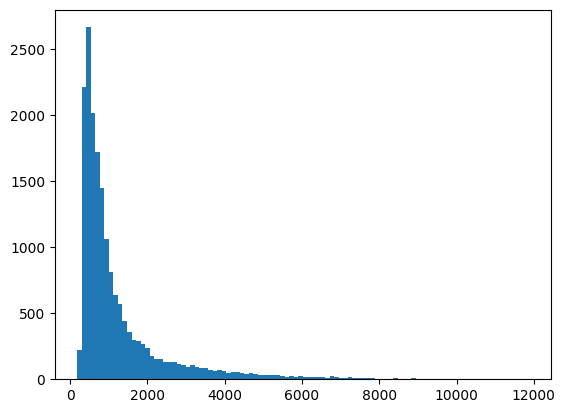

In [28]:
plt.hist(X_generated.sum(1), 100)
plt.show()

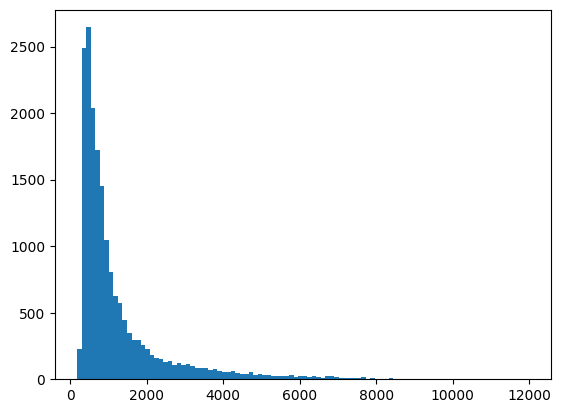

In [29]:
plt.hist(X.sum(1), 100)
plt.show()

In [30]:
(X_generated==0).sum(1).float().mean()

tensor(1756.7687)

In [31]:
(X==0).sum(1).float().mean()

tensor(1649.3105)

In [32]:
X.mean(1).mean()

tensor(0.6263)

In [33]:
X_generated.mean(1).mean()

tensor(0.6262)